# 랜덤포레스트

- parameter
       1. n_estimators : 랜덤포레스트의 결정트리 개수 지정
       2. max_feature : 최적 분할을 위해 고려할 최대 피쳐 개수 / 디폴트가 none(dt의 경우 noe)이 아니라 auto, 즉 sqrt
       3. max_depth : 트리의 최대 깊이 규정
       4. min_samples_leaf : 리프노드가 되기 위한 최소한의 샘플 데이터
       5. min_samples_split : 노드분할을 위한 최소한의 샘플 데이터
       6. ...

# UCI HAR Dataset

## 1. 기본 모델

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, plot_confusion_matrix
from sklearn.tree import plot_tree
from tqdm import tqdm

In [2]:
feature_name_df = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/features.txt',sep='\s+',
                             header=None, names = ['column_index','column_name'])
feature_name = feature_name_df.iloc[:,1].values.tolist()

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby(by='column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1])
                                                                                             if x[1]>0 else x[0], axis =1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis = 1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/features.txt',sep='\s+',
                             header=None, names = ['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    X_train = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/train/X_train.txt',sep='\s+', names = feature_name)
    X_test = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/test/X_test.txt',sep='\s+', names = feature_name)
    y_train = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/train/y_train.txt',sep='\s+',
                          header = None, names = ['action'])
    y_test = pd.read_csv('C:/Users/Park/_Python_data/UCI HAR Dataset/test/y_test.txt',sep='\s+',
                          header = None, names = ['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()
display(X_train)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [3]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


## 2. 최적 하이퍼파라미터 튜닝

In [4]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [100],
         'max_depth' : [6,8,10,12],
         'min_samples_leaf' : [8,12,18],
         'min_samples_split' : [8,16,20]}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=300,max_depth=10, min_samples_leaf = 8, min_samples_split = 8, random_state=0)
rf_clf1.fit(X_train,y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도 : 0.9165


<AxesSubplot:title={'center':'Feature Importances Top 20'}>

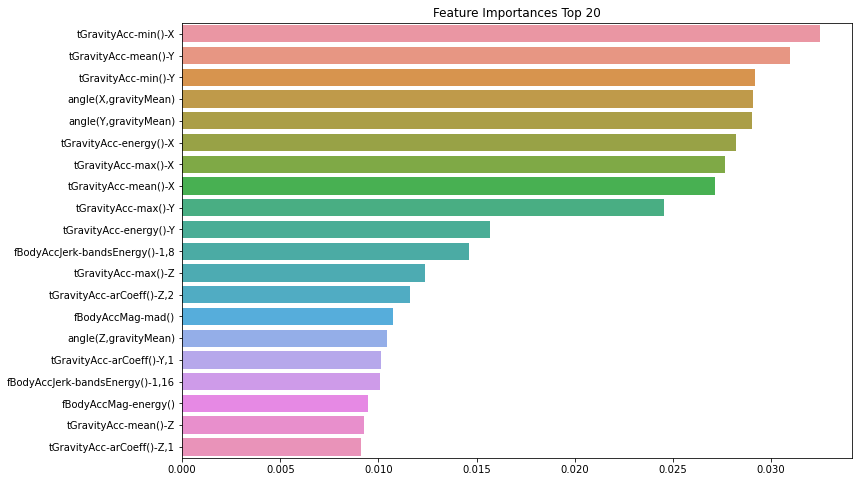

In [6]:
frt_importances_values = rf_clf1.feature_importances_
frt_importances = pd.Series(frt_importances_values, index = X_train.columns)
frt_top20 = frt_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(12,8))
plt.title('Feature Importances Top 20')
sns.barplot(x = frt_top20, y= frt_top20.index)

In [11]:
rf_clf1.predict_proba(X_train)

array([[1.09289617e-05, 1.01731602e-03, 1.30718954e-05, 1.47636646e-01,
        8.37900277e-01, 1.34217599e-02],
       [0.00000000e+00, 5.42888165e-06, 0.00000000e+00, 3.62351386e-02,
        9.61796713e-01, 1.96271994e-03],
       [0.00000000e+00, 1.90348941e-05, 0.00000000e+00, 2.43086060e-02,
        9.74793487e-01, 8.78872000e-04],
       ...,
       [1.40746935e-02, 9.70400814e-01, 1.48512633e-02, 2.41244306e-05,
        0.00000000e+00, 6.49105165e-04],
       [1.74687883e-02, 9.60770246e-01, 2.15406185e-02, 2.41244306e-05,
        1.44927536e-04, 5.12953845e-05],
       [1.30746860e-02, 9.61398160e-01, 2.45169633e-02, 2.41244306e-05,
        3.33333333e-04, 6.52732782e-04]])

# breast_cancer Data

## 1. 데이터 로드 및 단순 모델링

In [3]:
# 데이터 로드

breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns = ['diagnosis'])
display(X.describe())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
# 학습/평가 데이터 분할 및 스케일링

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify = y, random_state=2021)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# 단순 모델링

rfc = RandomForestClassifier(n_estimators = 10, random_state= 2021)
rfc.fit(X_train,y_train)

train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print('train set acc : {0:.3f} test set acc : {1:.3f}'.format(train_acc,test_acc))

train set acc : 1.000 test set acc : 0.959


## 2. 단일 하이퍼 파마미터 추정

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.27it/s]


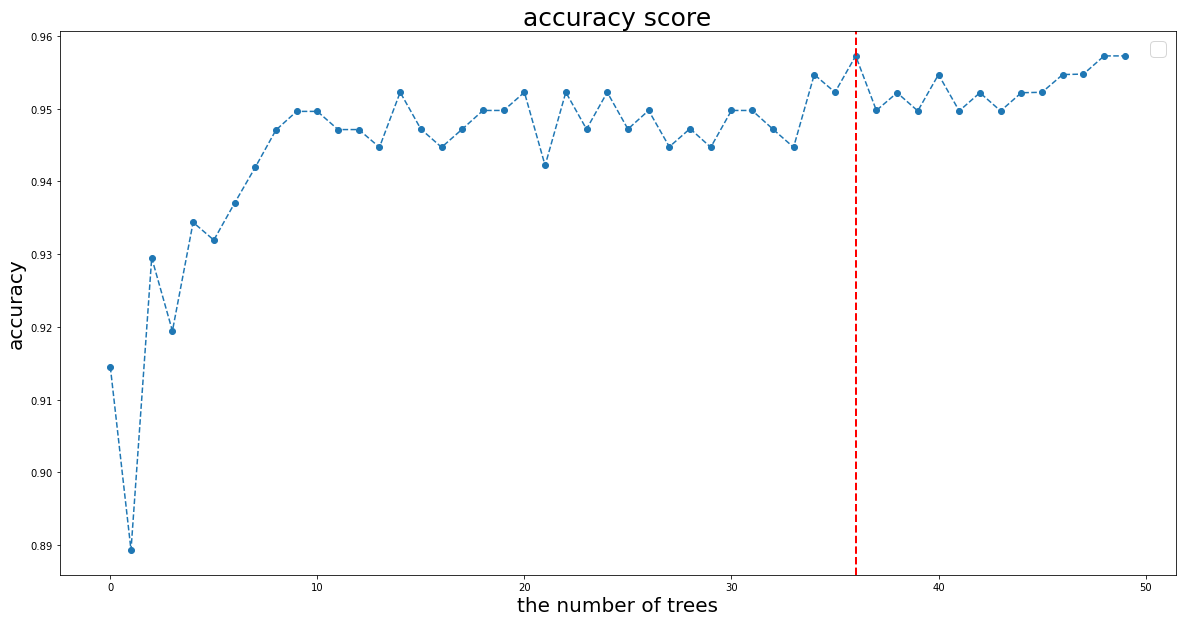

In [6]:
cv_score = []
estimator = [i for i in range(0,50,1)]

for i in tqdm(range(0,50,1)):
    rfc = RandomForestClassifier(n_estimators = i+1, n_jobs = -1, random_state = 2021)
    score = cross_val_score(rfc, X_train, y_train,cv=10, scoring='accuracy').mean()
    cv_score.append(score)

best_e = cv_score.index(max(cv_score))
plt.figure(figsize = (20,10))
plt.legend(['cross validatino score'], fontsize=20)
plt.plot(estimator, cv_score, marker = 'o', linestyle = '--')
plt.xlabel('the number of trees', fontsize=20)
plt.ylabel('accuracy', fontsize = 20)
plt.title('accuracy score',fontsize=25)
plt.axvline(best_e, color='r', linestyle='--', linewidth=2)   # axhline(): 축을 따라 수평선을 표시

In [7]:
print('최적 tree 개수 : {}'.format(best_e + 1))
print('-'*30)
print('train set accuracy(10 fold) : {:.4f}'.format(max(cv_score)))

최적 tree 개수 : 37
------------------------------
train set accuracy(10 fold) : 0.9572


In [8]:
# 최적 tree 개수 37개로 다시 모델링

rfc = RandomForestClassifier(n_estimators = 37, random_state= 2021)
rfc.fit(X_train,y_train)

train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print('train set acc : {0:.3f} test set acc : {1:.3f}'.format(train_acc,test_acc))

train set acc : 1.000 test set acc : 0.977


## 3. 전체 하이퍼 파마미터 추정 - gridsearchcv

In [9]:
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators' : [50, 60, 70],
    'max_depth' : [10,15,20],
    'max_leaf_nodes' : [50,100,200],
    'criterion' : ['gini','entropy'],
    'max_features' : ['auto','sqrt','log2']
}

cv_rfc = GridSearchCV(rfc, param_grid = param_grid, cv = 10, verbose=1,n_jobs=12)
cv_rfc.fit(X_train,y_train)
print(cv_rfc.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 50, 'n_estimators': 50}


In [10]:
result_table = pd.DataFrame(cv_rfc.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params','mean_test_score']])

                                                params  mean_test_score
81   {'criterion': 'entropy', 'max_depth': 10, 'max...         0.959808
147  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.959808
111  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.959808
117  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.959808
108  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.959808
..                                                 ...              ...
42   {'criterion': 'gini', 'max_depth': 15, 'max_fe...         0.947115
39   {'criterion': 'gini', 'max_depth': 15, 'max_fe...         0.947115
36   {'criterion': 'gini', 'max_depth': 15, 'max_fe...         0.947115
33   {'criterion': 'gini', 'max_depth': 15, 'max_fe...         0.947115
0    {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.947115

[162 rows x 2 columns]


In [11]:
# 도출된 최적 파라미터로 재학습

best_rfc = cv_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

train_pred = best_rfc.predict(X_train)
test_pred = best_rfc.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print('train set acc : {0:.3f} test set acc : {1:.3f}'.format(train_acc,test_acc))

train set acc : 1.000 test set acc : 0.982


## 4. 성능 평가

정확도 : 0.9825 / 민감도 : 0.9907 / 정밀도 : 0.9815


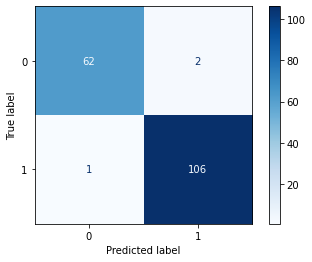

In [12]:
recall = recall_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
print('정확도 : {0:.4f} / 민감도 : {1:.4f} / 정밀도 : {2:.4f}'.format(test_acc, recall, precision))
plot_confusion_matrix(best_rfc, X_test, y_test, cmap='Blues')

,Features,Importances
0,worst radius,0.130206
1,worst area,0.129785
2,mean concave points,0.104198
3,worst perimeter,0.099340
4,worst concave points,0.084856
5,mean area,0.067207
6,mean concavity,0.046644
7,mean perimeter,0.044616
8,mean radius,0.036507
9,worst texture,0.031804


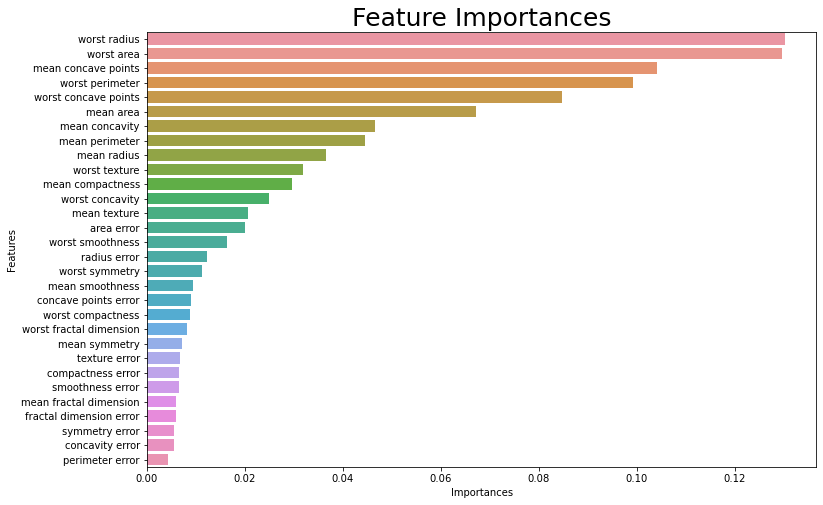

In [14]:
plt.figure(figsize=(12,8))
feature_importances = pd.Series(best_rfc.feature_importances_, index = breast_cancer.feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances = pd.DataFrame(feature_importances, columns=['Importances']).reset_index()
feature_importances = feature_importances.rename(columns={'index' : 'Features'})

sns.barplot(x=feature_importances.Importances, y= feature_importances.Features)
plt.title('Feature Importances', fontsize=25)
display(feature_importances)